# Mixtral

## Separate y-axis for off-chip traffic and on-chip requirement

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

def create_memory_cycles_plot(csv_files, x_labels=None, output_file=None, off_chip_scale = None, on_chip_scale = None, cycles_scale = None,):
    """
    Create a grouped bar chart with line overlay from multiple CSV files.
    
    Parameters:
    csv_files (list): List of CSV file paths
    x_labels (list, optional): Custom labels for x-axis. If None, uses filenames.
    output_file (str, optional): Path to save the plot
    """
    axis_font = 40
    legend_font = 28
    tick_font = 30
    x_tick_size = 28
    
    # Set up color palette
    color_palette = sns.color_palette(palette='tab20')
    
    # Validate x_labels if provided
    if x_labels is not None and len(x_labels) != len(csv_files):
        raise ValueError(f"Number of x_labels ({len(x_labels)}) must match number of CSV files ({len(csv_files)})")
    
    # Read and combine data from all CSV files
    all_data = []
    display_names = []
    
    for i, csv_file in enumerate(csv_files):
        try:
            # Read CSV file
            df = pd.read_csv(csv_file)
            
            # Get the first row (assuming single row per file based on your example)
            data_row = df.iloc[0]
            
            # Use custom label if provided, otherwise use filename
            label = x_labels[i] if x_labels else Path(csv_file).stem
            
            # Extract the required fields
            data_point = {
                'file': label,
                'off_chip_traffic_bytes': data_row['off_chip_traffic_bytes'],
                'on_chip_requirement_bytes': data_row['on_chip_requirement_bytes'],
                'cycles': data_row['cycles']
            }
            
            all_data.append(data_point)
            display_names.append(label)
            
        except Exception as e:
            print(f"Error reading {csv_file}: {e}")
            continue
    
    if not all_data:
        raise ValueError("No valid CSV files could be read")
    
    # Convert to DataFrame for easier manipulation
    df_combined = pd.DataFrame(all_data)
    
    # Set up the plot with multiple y-axes
    fig, ax1 = plt.subplots(figsize=(11, 10))
    
    # Position of bars on X axis
    x_pos = np.arange(len(display_names))
    width = 0.25  # Narrower width since we have more separate elements
    
    # Create first y-axis for off_chip_traffic_bytes
    bars1 = ax1.bar(x_pos - width, df_combined['off_chip_traffic_bytes'] / 1000, 
                    width, label='Off-Chip Traffic (KB)', 
                    color=color_palette[0], alpha=0.8)
    
    # Customize first y-axis (for off-chip traffic)
    # ax1.set_xlabel('Mixtral8x7B (batch=64, bf16)', fontsize=axis_font, fontweight='bold')
    ax1.set_ylabel('Off-Chip Traffic (KB)', fontsize=axis_font, fontweight='bold', color=color_palette[0])
    ax1.set_xticks(x_pos-width/2)
    ax1.set_xticklabels(display_names, ha='center', fontsize=x_tick_size, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax1.yaxis.get_offset_text().set_fontsize(tick_font)  # Adjust size as needed
    
    # Create second y-axis for on_chip_requirement_bytes
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x_pos, df_combined['on_chip_requirement_bytes'] / 1000, 
                    width, 
                    label='On-Chip Requirement (KB)', 
                    color=color_palette[2], alpha=0.8)
    
    # Customize second y-axis (for on-chip requirement)
    # ax2.set_ylabel('On-Chip Requirement (KB)', fontsize=axis_font, fontweight='bold', color=color_palette[2])
    ax2.tick_params(axis='y', labelcolor=color_palette[2], labelsize=tick_font)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2_offset_text = ax2.yaxis.get_offset_text()
    ax2_offset_text.set_fontsize(tick_font)
    ax2_offset_text.set_position((0.9, 1.02))  # (x, y) in axis coordinates
    
    
    # Create third y-axis for cycles
    ax3 = ax1.twinx()
    # Offset the third axis
    ax3.spines['right'].set_position(('outward', 60))
    
    # Create line plot for cycles
    line = ax3.plot(x_pos-width/2, df_combined['cycles'], 
                    color=color_palette[4], marker='o', linewidth=3, 
                    markersize=8, label='Cycles')
    
    
    # Customize third y-axis
    # ax3.set_ylabel('Cycles', fontsize=axis_font, fontweight='bold', color=color_palette[4])
    ax3.tick_params(axis='y', labelcolor=color_palette[4], labelsize=tick_font)
    ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax3_offset_text = ax3.yaxis.get_offset_text()
    ax3_offset_text.set_fontsize(tick_font)
    ax3_offset_text.set_position((1, 1.02))  # (x, y) in axis coordinates
    
    
    # ==================== Set Range ====================
    if off_chip_scale is not None:
        ax1.set_ylim(off_chip_scale) # off-chip traffic
    if on_chip_scale is not None:
        ax2.set_ylim(on_chip_scale) # on-chip requirement
    if cycles_scale is not None:
        ax3.set_ylim(cycles_scale) # cycles
    

    # Add value labels on bars and line
    # def add_value_labels_single_axis(bars, ax, suffix=""):
    #     for bar in bars:
    #         height = bar.get_height()
    #         ax.annotate(f'{height:,.0f}{suffix}',
    #                    xy=(bar.get_x() + bar.get_width() / 2, height),
    #                    xytext=(0, 3),  # 3 points vertical offset
    #                    textcoords="offset points",
    #                    ha='center', va='bottom',
    #                    fontsize=8, rotation=0)
    
    # Add labels to bars
    # add_value_labels_single_axis(bars1, ax1)
    # add_value_labels_single_axis(bars2, ax2)
    
    # Add value labels to line points
    # for i, (x, y) in enumerate(zip(x_pos, df_combined['cycles'])):
    #     ax3.annotate(f'{y:,.0f}',
    #         xy=(x-width/2, y),
    #         xytext=(0, 10),
    #         textcoords="offset points",
    #         ha='center', va='bottom',
    #         fontsize=8, color=color_palette[4], fontweight='bold')
    
    
    # Combine legends from all axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    
    # Create a single legend with all elements
    all_handles = lines1 + lines2 + lines3
    all_labels = labels1 + labels2 + labels3
    ax1.legend(all_handles, all_labels, loc='upper right', fontsize=legend_font)
    
    # Add title and grid
    # plt.title('Memory Traffic and Cycles Analysis', fontsize=16, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Save plot if output file specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")
    
    # Show plot
    plt.show()

Plot saved to /home/ginasohn/step_tl/visualize/mixtral_512_1792_iter008_layer_010.pdf


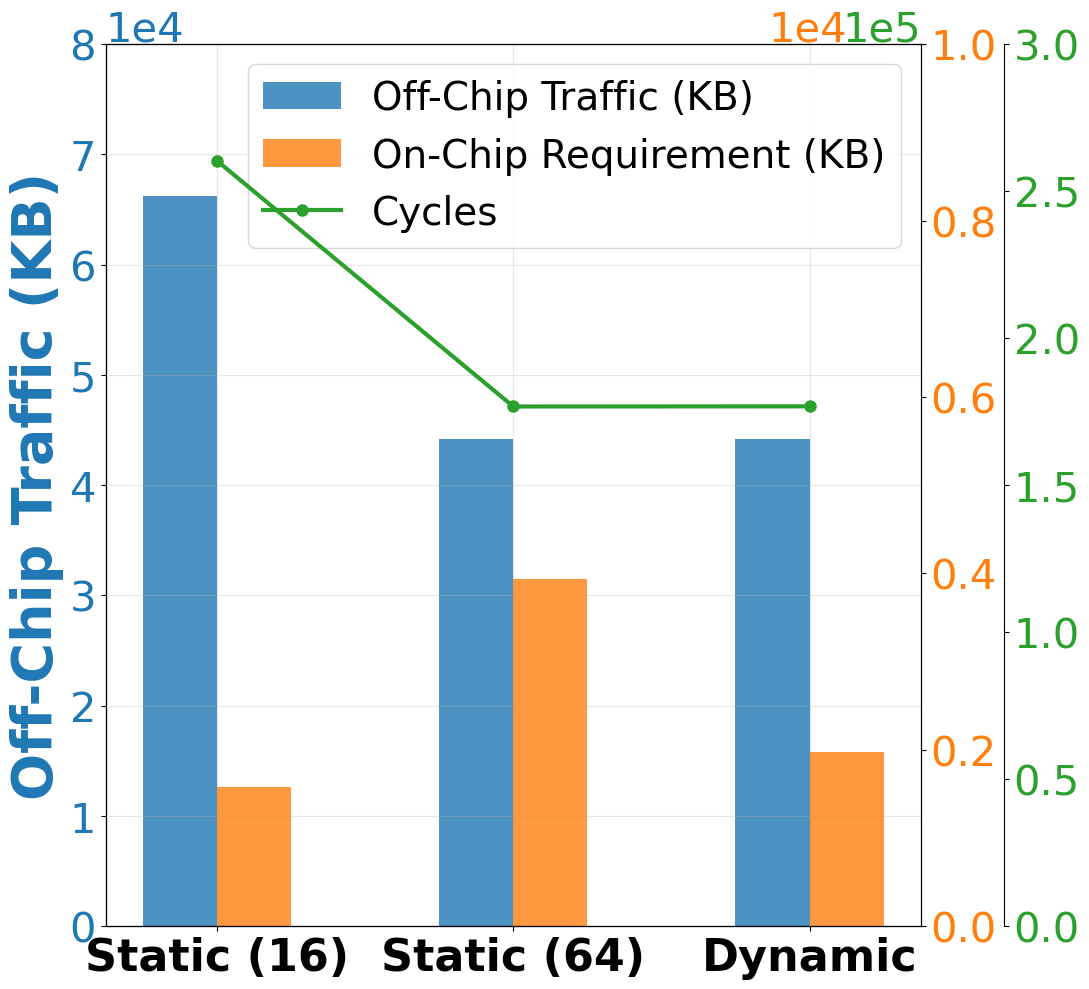

In [ ]:
dyn_tile = "/home/ginasohn/step_tl/mixtral_512_1792_round_16_iter008_layer_010_n_dyn_f32.csv"
static_64_tile = "/home/ginasohn/step_tl/mixtral_512_1792_80gb_max4192_iter008_layer_010_n64_f32.csv"
static_16_tile = "/home/ginasohn/step_tl/mixtral_512_1792_80gb_max4192_iter008_layer_010_n16_f32.csv"

csv_files = [static_16_tile,static_64_tile, dyn_tile]
output_file = "/home/ginasohn/step_tl/visualize/mixtral_512_1792_iter008_layer_010.pdf"
# output_file = None
labels = ['Static (16)','Static (64)', 'Dynamic', ]

off_chip_scale = (0,8*1e4) # off-chip traffic
on_chip_scale = (0,1e4) # on-chip requirement
cycles_scale = (0,3*1e5) # cycles

create_memory_cycles_plot(csv_files, x_labels=labels, output_file=output_file, off_chip_scale=off_chip_scale, on_chip_scale=on_chip_scale, cycles_scale=cycles_scale)

Plot saved to /home/ginasohn/step_tl/visualize/mixtral_4096_14336_iter008_layer_010.pdf


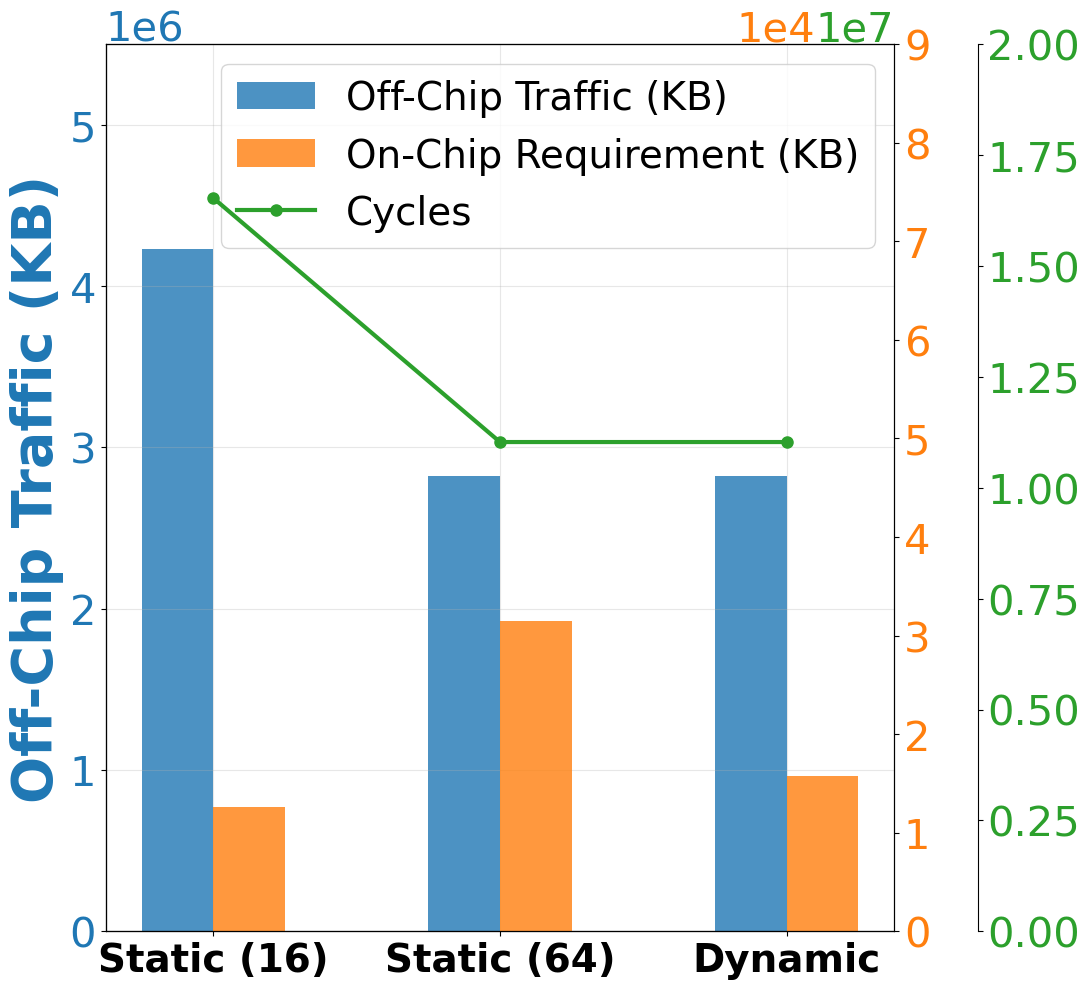

In [ ]:
dyn_tile = "/home/ginasohn/step_tl/mixtral_4096_14336_round_16_iter008_layer_010_n_dyn_f32.csv"
static_64_tile = "/home/ginasohn/step_tl/mixtral_4096_14336_80gb_max4192_iter008_layer_010_n64_f32.csv"
static_16_tile = "/home/ginasohn/step_tl/mixtral_4096_14336_80gb_max4192_iter008_layer_010_n16_f32.csv"

csv_files = [static_16_tile,static_64_tile, dyn_tile]
output_file = "/home/ginasohn/step_tl/dyn_tiling/mixtral_4096_14336_iter008_layer_010.pdf"
# output_file = None
labels = ['Static (16)','Static (64)', 'Dynamic', ]

off_chip_scale = None
# on_chip_scale = None
# cycles_scale = None
off_chip_scale = (0,5.5*1e6) # off-chip traffic
on_chip_scale = (0,9*1e4) # on-chip requirement
cycles_scale = (0,2*1e7) # cycles

create_memory_cycles_plot(csv_files, x_labels=labels, output_file=output_file, off_chip_scale=off_chip_scale, on_chip_scale=on_chip_scale, cycles_scale=cycles_scale)

Plot saved to /home/ginasohn/step_tl/dyn_tiling/mixtral_4096_14336_iter008_layer_010.pdf


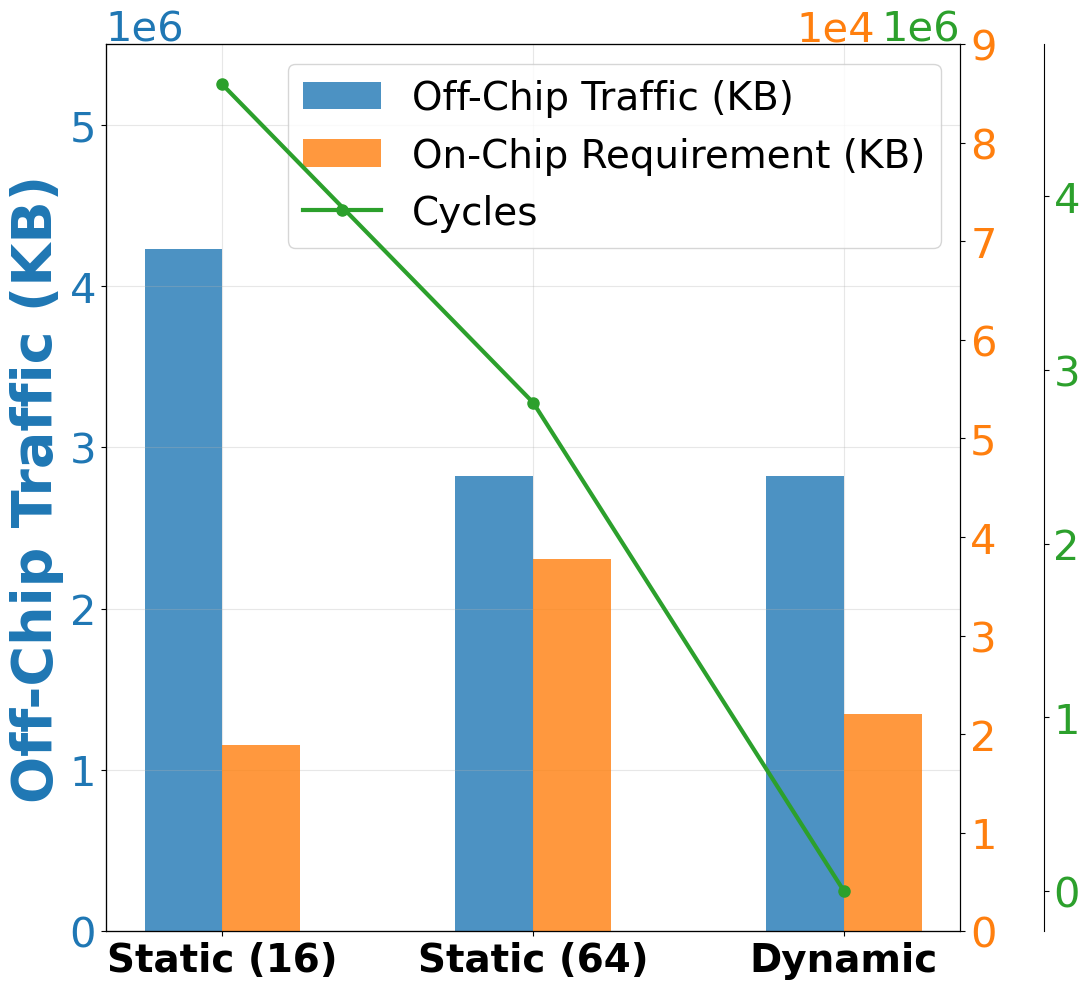

In [6]:
dyn_tile = "/home/ginasohn/step_tl/dyn_tiling/mixtral_4096_14336_round_16_iter008_layer_010_n_dyn_f64.csv"
static_64_tile = "/home/ginasohn/step_tl/dyn_tiling/mixtral_4096_14336_80gb_max4192_iter008_layer_010_n64_f64.csv"
static_16_tile = "/home/ginasohn/step_tl/dyn_tiling/mixtral_4096_14336_80gb_max4192_iter008_layer_010_n16_f64.csv"

csv_files = [static_16_tile,static_64_tile, dyn_tile]
output_file = "/home/ginasohn/step_tl/dyn_tiling/mixtral_4096_14336_iter008_layer_010.pdf"
# output_file = None
labels = ['Static (16)','Static (64)', 'Dynamic', ]

off_chip_scale = None
# on_chip_scale = None
cycles_scale = None
off_chip_scale = (0,5.5*1e6) # off-chip traffic
on_chip_scale = (0,9*1e4) # on-chip requirement
# cycles_scale = (0,2*1e7) # cycles

create_memory_cycles_plot(csv_files, x_labels=labels, output_file=output_file, off_chip_scale=off_chip_scale, on_chip_scale=on_chip_scale, cycles_scale=cycles_scale)

## Single y axis for off-chip traffic and on-chip requirement

# Qwen

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

def create_memory_cycles_plot_left(csv_files, x_labels=None, output_file=None, off_chip_scale = None, on_chip_scale = None, cycles_scale = None,):
    """
    Create a grouped bar chart with line overlay from multiple CSV files.
    
    Parameters:
    csv_files (list): List of CSV file paths
    x_labels (list, optional): Custom labels for x-axis. If None, uses filenames.
    output_file (str, optional): Path to save the plot
    """
    axis_font = 40
    legend_font = 28
    tick_font = 30
    x_tick_size = 28
    
    # Set up color palette
    color_palette = sns.color_palette(palette='tab20')
    
    # Validate x_labels if provided
    if x_labels is not None and len(x_labels) != len(csv_files):
        raise ValueError(f"Number of x_labels ({len(x_labels)}) must match number of CSV files ({len(csv_files)})")
    
    # Read and combine data from all CSV files
    all_data = []
    display_names = []
    
    for i, csv_file in enumerate(csv_files):
        try:
            # Read CSV file
            df = pd.read_csv(csv_file)
            
            # Get the first row (assuming single row per file based on your example)
            data_row = df.iloc[0]
            
            # Use custom label if provided, otherwise use filename
            label = x_labels[i] if x_labels else Path(csv_file).stem
            
            # Extract the required fields
            data_point = {
                'file': label,
                'off_chip_traffic_bytes': data_row['off_chip_traffic_bytes'],
                'on_chip_requirement_bytes': data_row['on_chip_requirement_bytes'],
                'cycles': data_row['cycles']
            }
            
            all_data.append(data_point)
            display_names.append(label)
            
        except Exception as e:
            print(f"Error reading {csv_file}: {e}")
            continue
    
    if not all_data:
        raise ValueError("No valid CSV files could be read")
    
    # Convert to DataFrame for easier manipulation
    df_combined = pd.DataFrame(all_data)
    
    # Set up the plot with multiple y-axes
    fig, ax1 = plt.subplots(figsize=(11, 10))
    
    # Position of bars on X axis
    x_pos = np.arange(len(display_names))
    width = 0.25  # Narrower width since we have more separate elements
    
    # Create first y-axis for off_chip_traffic_bytes
    bars1 = ax1.bar(x_pos - width, df_combined['off_chip_traffic_bytes'] / 1000, 
                    width, label='Off-Chip Traffic (KB)', 
                    color=color_palette[0], alpha=0.8)
    
    # Customize first y-axis (for off-chip traffic)
    # ax1.set_xlabel('Mixtral8x7B (batch=64, bf16)', fontsize=axis_font, fontweight='bold')
    # ax1.set_ylabel('Off-Chip Traffic (KB)', fontsize=axis_font, fontweight='bold', color=color_palette[0])
    ax1.set_xticks(x_pos-width/2)
    ax1.set_xticklabels(display_names, ha='center', fontsize=x_tick_size, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax1.yaxis.get_offset_text().set_fontsize(tick_font)  # Adjust size as needed
    
    # Create second y-axis for on_chip_requirement_bytes
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x_pos, df_combined['on_chip_requirement_bytes'] / 1000, 
                    width, 
                    label='On-Chip Requirement (KB)', 
                    color=color_palette[2], alpha=0.8)
    
    # Customize second y-axis (for on-chip requirement)
    ax2.set_ylabel('On-Chip Requirement (KB)', fontsize=axis_font, fontweight='bold', color=color_palette[2])
    ax2.tick_params(axis='y', labelcolor=color_palette[2], labelsize=tick_font)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2_offset_text = ax2.yaxis.get_offset_text()
    ax2_offset_text.set_fontsize(tick_font)
    ax2_offset_text.set_position((0.89, 1.02))  # (x, y) in axis coordinates
    
    
    # Create third y-axis for cycles
    ax3 = ax1.twinx()
    # Offset the third axis
    ax3.spines['right'].set_position(('outward', 80))
    
    # Create line plot for cycles
    line = ax3.plot(x_pos-width/2, df_combined['cycles'], 
                    color=color_palette[4], marker='o', linewidth=3, 
                    markersize=8, label='Cycles')
    
    
    # Customize third y-axis
    ax3.set_ylabel('Cycles', fontsize=axis_font, fontweight='bold', color=color_palette[4])
    ax3.tick_params(axis='y', labelcolor=color_palette[4], labelsize=tick_font)
    ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax3_offset_text = ax3.yaxis.get_offset_text()
    ax3_offset_text.set_fontsize(tick_font)
    ax3_offset_text.set_position((1, 1.02))  # (x, y) in axis coordinates
    
    
    # ==================== Set Range ====================
    if off_chip_scale is not None:
        ax1.set_ylim(off_chip_scale) # off-chip traffic
    if on_chip_scale is not None:
        ax2.set_ylim(on_chip_scale) # on-chip requirement
    if cycles_scale is not None:
        ax3.set_ylim(cycles_scale) # cycles
    

    # Add value labels on bars and line
    # def add_value_labels_single_axis(bars, ax, suffix=""):
    #     for bar in bars:
    #         height = bar.get_height()
    #         ax.annotate(f'{height:,.0f}{suffix}',
    #                    xy=(bar.get_x() + bar.get_width() / 2, height),
    #                    xytext=(0, 3),  # 3 points vertical offset
    #                    textcoords="offset points",
    #                    ha='center', va='bottom',
    #                    fontsize=8, rotation=0)
    
    # Add labels to bars
    # add_value_labels_single_axis(bars1, ax1)
    # add_value_labels_single_axis(bars2, ax2)
    
    # Add value labels to line points
    # for i, (x, y) in enumerate(zip(x_pos, df_combined['cycles'])):
    #     ax3.annotate(f'{y:,.0f}',
    #         xy=(x-width/2, y),
    #         xytext=(0, 10),
    #         textcoords="offset points",
    #         ha='center', va='bottom',
    #         fontsize=8, color=color_palette[4], fontweight='bold')
    
    
    # Combine legends from all axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    
    # Create a single legend with all elements
    all_handles = lines1 + lines2 + lines3
    all_labels = labels1 + labels2 + labels3
    ax1.legend(all_handles, all_labels, loc='upper right', fontsize=legend_font)
    
    # Add title and grid
    # plt.title('Memory Traffic and Cycles Analysis', fontsize=16, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Save plot if output file specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")
    
    # Show plot
    plt.show()

Plot saved to /home/ginasohn/step_tl/visualize/qwen_2048_768_iter032_layer_012.pdf


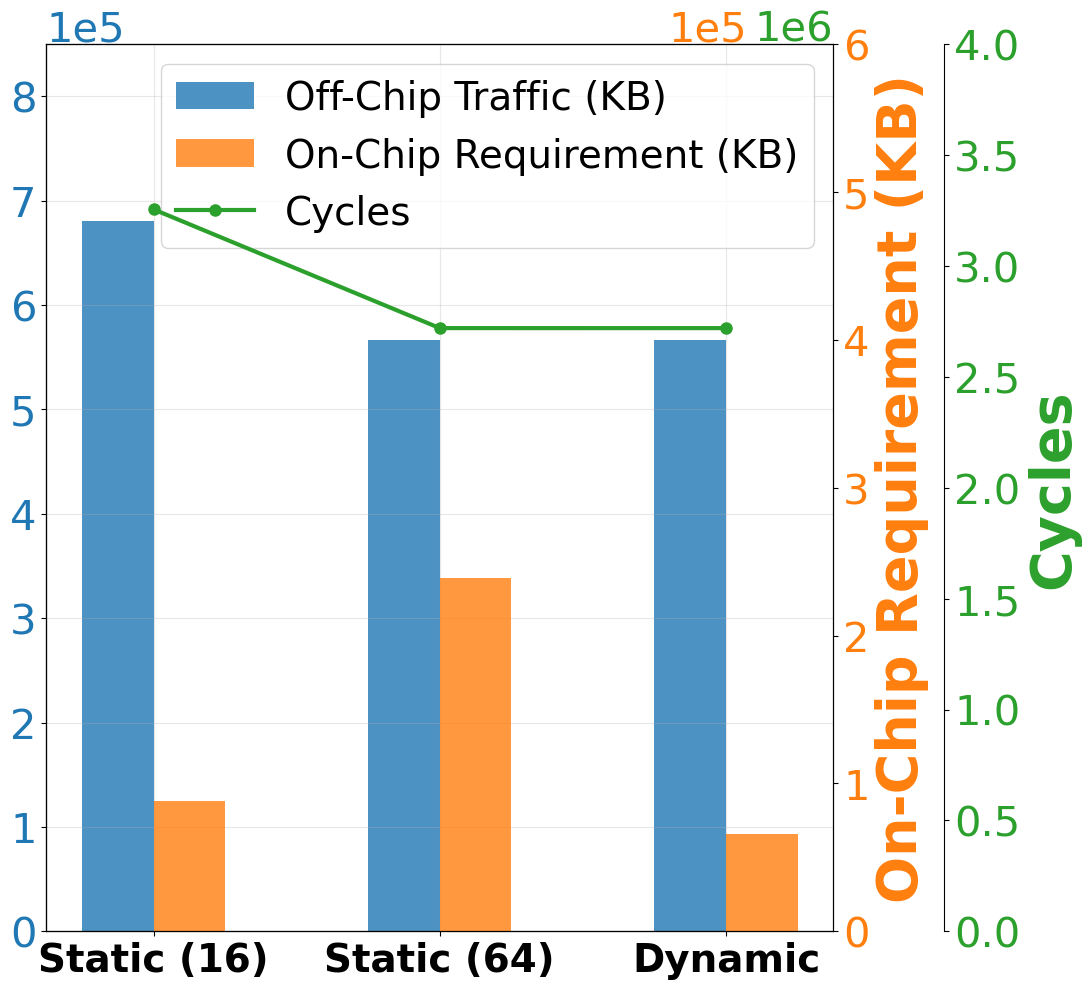

In [90]:
dyn_tile = "/home/ginasohn/step_tl/qwen_2048_768_round_16_iter032_layer_012_n_dyn_f24.csv"
static_64_tile = "/home/ginasohn/step_tl/qwen_2048_768_iter032_layer_012_n64_f24.csv"
static_16_tile = "/home/ginasohn/step_tl/qwen_2048_768_iter032_layer_012_n16_f24.csv"

csv_files = [static_16_tile,static_64_tile, dyn_tile]
output_file = "/home/ginasohn/step_tl/visualize/qwen_2048_768_iter032_layer_012.pdf"
# output_file = None
labels = ['Static (16)','Static (64)', 'Dynamic', ]

off_chip_scale = None
on_chip_scale = None
cycles_scale = None
off_chip_scale = (0,8.5*1e5) # off-chip traffic
on_chip_scale = (0,6*1e5) # on-chip requirement
cycles_scale = (0,4*1e6) # cycles

create_memory_cycles_plot_left(csv_files, x_labels=labels, output_file=output_file, off_chip_scale=off_chip_scale, on_chip_scale=on_chip_scale, cycles_scale=cycles_scale)